In [1]:
%load_ext autoreload

In [30]:
# Custom Packages
%aimport AccuracyMetrics
%aimport BPCA
%aimport Helpers
%aimport KNN
%aimport LR
%aimport MCROC
%aimport RF
%aimport SVM

import AccuracyMetrics
import BPCA
import Helpers
import KNN
import LR
import MCROC
import RF
import SVM

In [4]:
from AccuracyMetrics import *
from BPCA import *
from Helpers import *
from KNN import *
from LR import *
from MCROC import *
from RF import *
from SVM import *

In [5]:
# take out the trash
import gc
import warnings
gc.collect()
warnings.filterwarnings('ignore')

# Python magic
%matplotlib inline

# Base packages
import gc, sys, re, os, math
from time import strptime, mktime

# Data processing/preprocessing/modeling packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

# Sklearn: KNN, SVM, LR, RF
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
X_train2 = pd.read_csv('../data/1/TrainData2.txt', delimiter='\s+', header=None)
y_train2 = pd.read_csv('../data/1/TrainLabel2.txt', delimiter='\n', header=None)
X_test2 = pd.read_csv('../data/1/TestData2.txt', delimiter='\s+', header=None)

In [7]:
X_train2_cmp, X_test2_cmp = trainPCA(X_train2, X_test2)

X_train Variance: 0.9287852222496773
X_train Shape: (100, 9182)
X_train Variance: 1.0
X_train Shape: (74, 74)


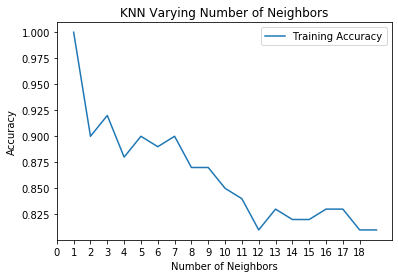

In [8]:
n_neighbors2, train_accuracy2 = testK(X_train2_cmp, y_train2)
plotTestK(n_neighbors2, train_accuracy2)

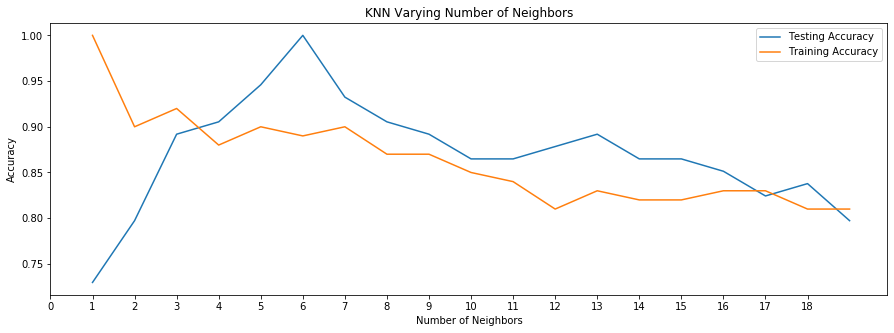

In [9]:
y_test2 = getTestLabelsKNN(6, X_train2_cmp, y_train2, X_test2_cmp)
n2, test_acc2, train_acc2 = optimizeK(X_train2_cmp, y_train2, X_test2_cmp, y_test2, 20)
plotK(n2, test_acc2, train_acc2, [15, 5])

In [31]:
n_neighbors2=10
knn_score2, knn_y_pred2 = runKNN(n_neighbors2, X_train2_cmp, y_train2, X_test2_cmp, y_test2)
print(f'Accuracy: {knn_score2}')

Accuracy: 0.8648648648648649


In [18]:
knn_keys1, knn_vals1, knn_labels1 = countUniqueValues(knn_y_pred2)

Keys: dict_keys([9, 1, 6, 4, 5, 8, 11, 3, 2])
Values: dict_values([2, 15, 23, 19, 1, 5, 2, 4, 3])
Labels: [9, 1, 6, 4, 5, 8, 11, 3, 2]


In [19]:
getScoresKNN(n_neighbors2, y_test2, knn_y_pred2)
pd.crosstab(y_test2, knn_y_pred2, rownames=['True'], colnames=['Predicted'], margins=True)

KNN Accuracy Score, k=3: 0.8918918918918919

KNN Confusion Matrix, k=3

[[13  0  0  1  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0]
 [ 1  0  0 18  0  0  0  1  0]
 [ 0  0  0  0  1  1  0  0  0]
 [ 0  2  0  0  0 22  0  0  0]
 [ 1  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1]]

		  KNN Classification Report, k=3

              precision    recall  f1-score   support

           1       0.87      0.87      0.87        15
           2       0.33      1.00      0.50         1
           3       1.00      1.00      1.00         4
           4       0.95      0.90      0.92        20
           5       1.00      0.50      0.67         2
           6       0.96      0.92      0.94        24
           8       1.00      0.83      0.91         6
           9       0.50      1.00      0.67         1
          11       0.50      1.00      0.67         1

    accuracy                           0.89        74
   macro avg       0.79 

Predicted,1,2,3,4,5,6,8,9,11,All
True,,,,,,,,,,
1,13,0,0,1,0,0,0,0,1,15
2,0,1,0,0,0,0,0,0,0,1
3,0,0,4,0,0,0,0,0,0,4
4,1,0,0,18,0,0,0,1,0,20
5,0,0,0,0,1,1,0,0,0,2
6,0,2,0,0,0,22,0,0,0,24
8,1,0,0,0,0,0,5,0,0,6
9,0,0,0,0,0,0,0,1,0,1
11,0,0,0,0,0,0,0,0,1,1


In [32]:
def calcMultiClassROCAUC(X_train, y_train, X_test, y_test, **kwargs):
    for k,v in kwargs.items():
        model = kwargs['model']
        tuner = kwargs['tuner']
        tuner_val = kwargs['tuner_val']
        dec = kwargs['dec']
        labels = kwargs['labels']
        
    y_train_bin = label_binarize(y_train, classes=labels)
    n_classes = y_train_bin.shape[1]
    y_test_bin = label_binarize(y_test, classes=labels)

    clf = OneVsRestClassifier(SVC(kernel='sigmoid', probability=True, random_state=0))
    y_score = clf.fit(X_train, y_train_bin).decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],  label=f'{model} Micro-Avg Area: {round(roc_auc["micro"], 4)}')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{model} Area: {round(roc_auc[i], 4)}')
        if dec == True:
            plt.title(f'{model} ROC Curve, Label {labels[i]}, {tuner}={tuner_val}')
            tuner_val -= 1
        else:
            plt.title(f'{model} ROC Curve, Label {labels[i]}')
        plt.plot([0, 1], [0, 1], label='tpr-fpr line')
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.show()

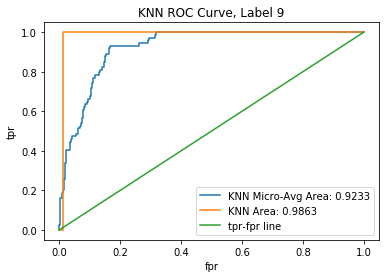

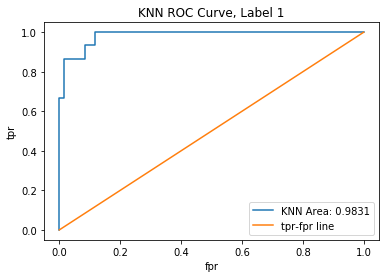

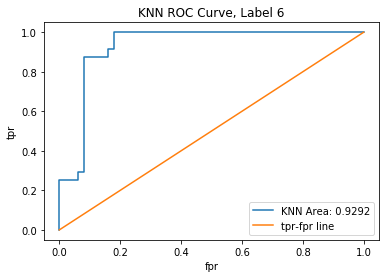

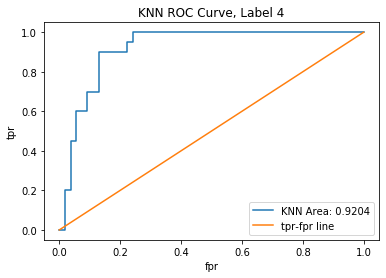

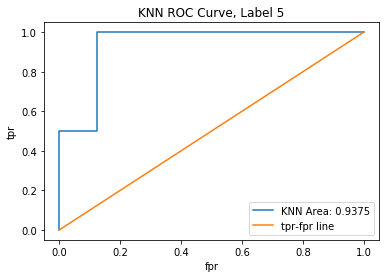

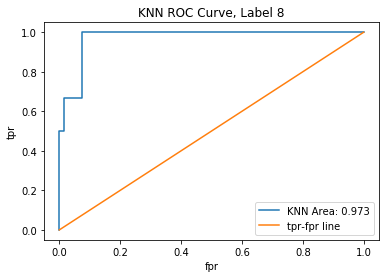

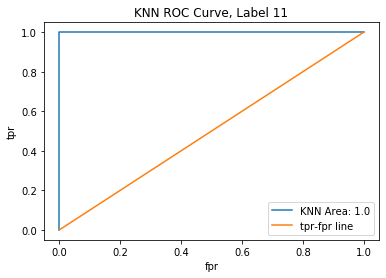

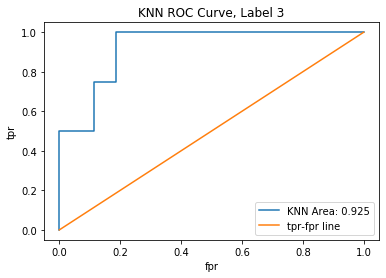

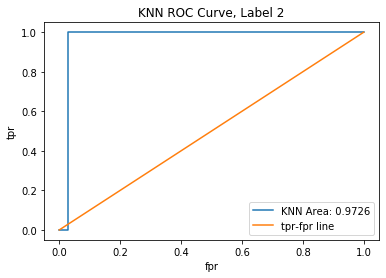

In [33]:
calcMultiClassROCAUC(X_train2_cmp, y_train2, X_test2_cmp, y_test2, model='KNN', tuner='k',\
 tuner_val=n_neighbors2, labels=labels1, dec=False)

In [22]:
## PLACEHOLDER FOR SVM DS4

In [23]:
c2 = 10
lr_cma2, lr_cr2, lr_acc2, lr_y_pred2, ky2, val2  = runLogisticRegression(c2, X_train2_cmp, y_train2, X_test2_cmp, y_test2)

print(f'Logistic Regression Highest Accuracy Score, c={ky2}: {val2}\n')
print(f'Logistic Regression Most Accurate Confusion Matrix\n\n{lr_cma2[ky2]}\n')
pd.crosstab(y_test2, lr_y_pred2[ky2], rownames=['True'], colnames=['Predicted'], margins=True)

Logistic Regression Highest Accuracy Score, c=5: 0.5405405405405406

Logistic Regression Most Accurate Confusion Matrix

[[ 8  0  0  0  2  0  0  1  0  3  1]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  1  1  0  0]
 [ 0  0  1 11  3  0  0  0  3  2  0]
 [ 0  1  0  0  1  0  0  0  0  0  0]
 [ 0  1  2  0  2 12  2  0  1  1  3]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  1  1]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1]]



Predicted,1,2,3,4,5,6,7,8,9,10,11,All
True,,,,,,,,,,,,
1,8,0,0,0,2,0,0,1,0,3,1,15
2,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0,2,0,0,0,0,1,1,0,0,4
4,0,0,1,11,3,0,0,0,3,2,0,20
5,0,1,0,0,1,0,0,0,0,0,0,2
6,0,1,2,0,2,12,2,0,1,1,3,24
8,0,0,0,0,0,0,0,4,0,1,1,6
9,0,1,0,0,0,0,0,0,0,0,0,1
11,0,0,0,0,0,0,0,0,0,0,1,1


In [1]:
lr_keys2, lr_vals2, lr_labels2 = countUniqueValues(lr_y_pred2[ky2])

NameError: name 'countUniqueValues' is not defined

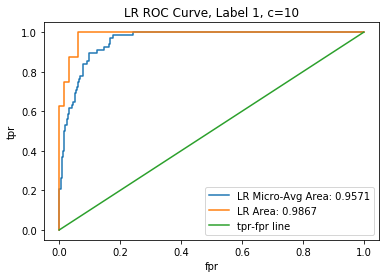

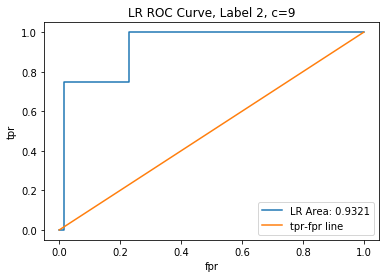

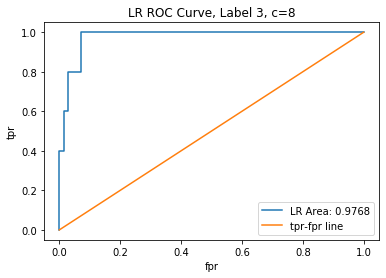

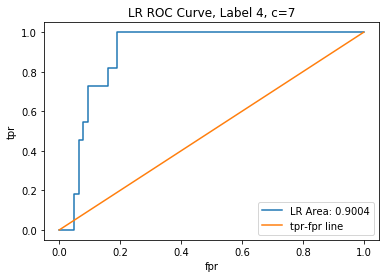

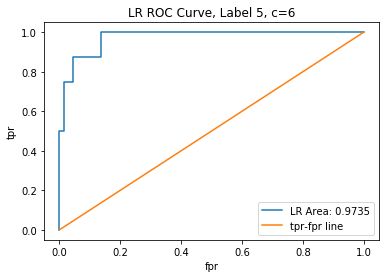

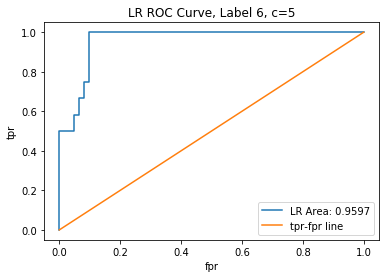

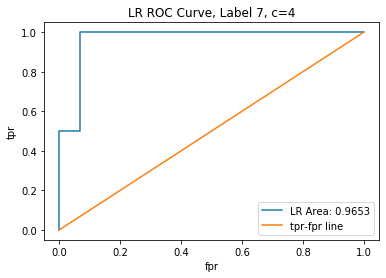

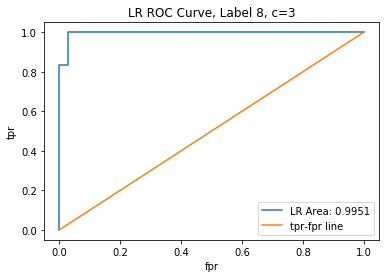

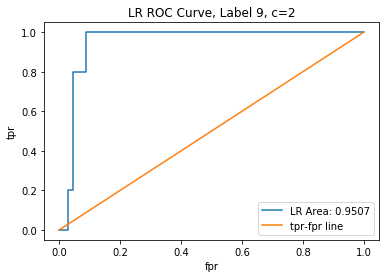

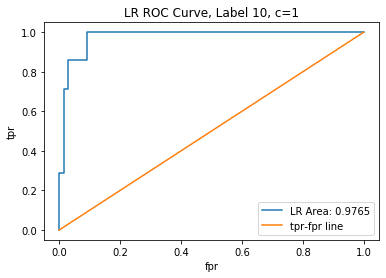

In [29]:
calcMultiClassROCAUC(X_train2_cmp, y_train2, X_test2_cmp, lr_y_pred2[ky2], model='LR', tuner='c', tuner_val=ky2, labels=lr_labels2, dec=False)